# Gaussian Process Regression

A Gaussian Process (GP) is a Gaussian distribution over a family of functions.  GP regression fits a GP to a given set of training data.  The use of Gaussians allow the modeling of similarity (through correlation) between data points.  For example, given two points $(x_{1},f_{1})$, $(x_{2},f_{2})$, if $x_{1}$ and $x_{2}$ are close to one another, then we would expect $f_{1}$ and $f_{2}$ to also be close to one another.  This implies a notion of smootheness of the functions in the GP which is captured by the Radial Basis Function (RBF) kernel.  This kernel is used to construct the covaraince matrix of the GP prior and posterior distributions.

sources: https://github.com/jwangjie/Gaussian-Processes-Regression-Tutorial, https://youtu.be/4vGiHC35j9s

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

## Radial Basis Function Kernel

The radial basis function kernel is given by:

\begin{equation}
\kappa (x_{i},x_{j}) = \sigma_{f}^{2} \text{ exp} \Big( -\frac{1}{2l}(x_{i}-x_{j})^{T}(x_{i}-x_{j})\Big)
\end{equation}

where $\sigma_{f}$ and $l$ are hyperparameters.

In [2]:
#Define the RBF kernel
#from Nando De Freitas youtube video
def kernel(a, b, l = 1.0, sigma = 1.0):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return sigma * np.exp(-0.5/l * sqdist)

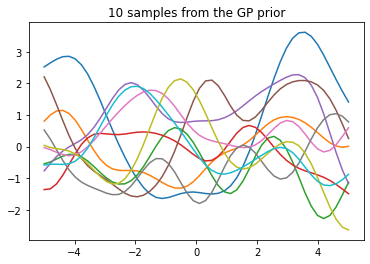

In [3]:
#Plot the kernalized prior distribution
n = 50
X_test = np.linspace(-5,5,n).reshape(-1,1)
K_ = kernel(X_test,X_test,)

#draw samples
num_samples = 10
L = LA.cholesky(K_ + 1e-6 * np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,num_samples)))

plt.plot(X_test,f_prior)
plt.title(str(num_samples) + " samples from the GP prior")
plt.show()

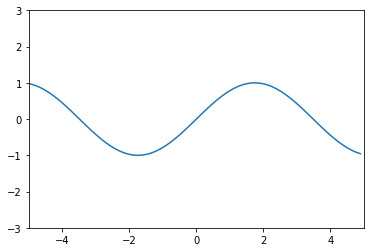

In [4]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x = np.arange(-5, 5, 0.1)

plt.plot(x, f(x))
plt.axis([-5, 5, -3, 3])
plt.show()

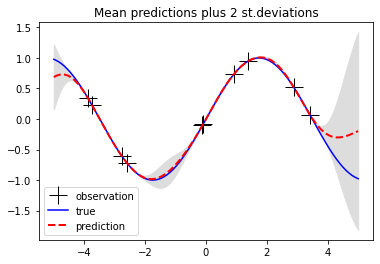

In [11]:
#Compute the posterior (conditional distribution)

#Noisy function observations (training data)
N = 10     #number of observations
s = 0.00005   #variance of noise
X = np.random.uniform(-5,5,size=(N,1))
y = f(X) + s*np.random.rand(N)

#compute L (square root of covariance matrix)
K = kernel(X, X, l = 1.0, sigma = 1.0)
L = LA.cholesky(K + s*np.eye(N))

#compute testing set to make predictions
n = 200     #number of points to predict
Xtest = np.linspace(-5,5,n).reshape(-1,1)

#compute mean of test set
#note trick to avoid taking matrix inverse
#k_star = kernel(X,Xtest)
#v = l\k_star
Lk = LA.solve(L, kernel(X, Xtest))
#alpha = LA.solve(L,y)
mu_star = np.dot(Lk.T, LA.solve(L,y))

#compute variance of test set
K_star_star = kernel(Xtest,Xtest)
s_ = np.diag(K_star_star) - np.sum(Lk**2,axis=0)
s_star = np.sqrt(s_)

#Plot posterior statistics
plt.figure(1)
plt.clf()
plt.plot(X, y, 'k+', ms=18, label='observation')
plt.plot(Xtest, f(Xtest), 'b-', label='true')
plt.gca().fill_between(Xtest.flat, mu_star-2*s_, mu_star+2*s_, color="#dddddd")
plt.plot(Xtest, mu_star, 'r--', lw=2, label='prediction')
plt.title('Mean predictions plus 2 st.deviations')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

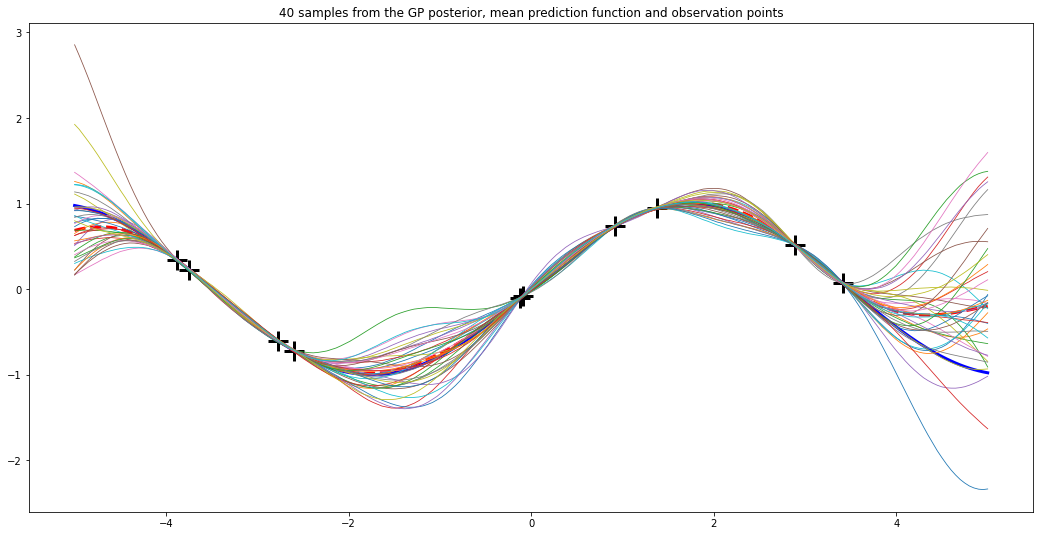

In [12]:
#Draw samples from the posterior distribution
L = LA.cholesky(K_star_star + 1e-6 * np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu_star.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,40)))

#plot
plt.figure(2)
plt.clf()
plt.figure(figsize=(18,9))
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
plt.plot(Xtest, f(Xtest), 'b-', label='true', linewidth=3)
plt.plot(Xtest, mu_star, 'r--', linewidth=3)
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('40 samples from the GP posterior, mean prediction function and observation points')
plt.show()